In [2]:
import torch 
import torch.nn as nn 
from urllib.request import urlopen
import pickle
import matplotlib.pyplot as plt

url = 'https://github.com/greydanus/mnist1d/raw/master/mnist1d_data.pkl'
data = pickle.load(urlopen(url))

In [3]:
print(data.keys())

dict_keys(['x', 'x_test', 'y', 'y_test', 't', 'templates'])


In [4]:
print(len(data['x']))
print(len(data['y']))
print(len(data['x_test']))
print(len(data['y_test']))
print(len(data['t']))
print(len(data['templates']))

4000
4000
1000
1000
40
3


In [5]:
print(data['y'][:10])

[2 6 4 5 6 6 6 0 3 1]


In [6]:
print(data['x'][0].shape)

(40,)


In [7]:

# The MNIST-1D dataset | 2020
# Sam Greydanus

import numpy as np
import os
import requests

def get_dataset_args(as_dict=False):
    """ Generate dictionary with dataset properties

    Parameters
    ----------
    as_dict : bool, optional
        if true, return the dataset properties as dictionary; if false, return an ObjectView, by default False

    Returns
    -------
    _type_
        _description_
    """
    arg_dict = {'num_samples': 5000,
            'train_split': 0.8,
            'template_len': 12,
            'padding': [36,60],
            'scale_coeff': .4, 
            'max_translation': 48,
            'corr_noise_scale': 0.25,
            'iid_noise_scale': 2e-2,
            'shear_scale': 0.75,
            'shuffle_seq': False,
            'final_seq_length': 40,
            'seed': 42,
            'url': 'https://github.com/greydanus/mnist1d/raw/master/mnist1d_data.pkl'}
    return arg_dict if as_dict else ObjectView(arg_dict)


# basic 1D templates for the 10 digits
def get_templates():
    d0 = np.asarray([5,6,6.5,6.75,7,7,7,7,6.75,6.5,6,5])
    d1 = np.asarray([5,3,3,3.4,3.8,4.2,4.6,5,5.4,5.8,5,5])
    d2 = np.asarray([5,6,6.5,6.5,6,5.25,4.75,4,3.5,3.5,4,5])
    d3 = np.asarray([5,6,6.5,6.5,6,5,5,6,6.5,6.5,6,5])
    d4 = np.asarray([5,4.4,3.8,3.2,2.6,2.6,5,5,5,5,5,5])
    d5 = np.asarray([5,3,3,3,3,5,6,6.5,6.5,6,4.5,5])
    d6 = np.asarray([5,4,3.5,3.25,3,3,3,3,3.25,3.5,4,5])
    d7 = np.asarray([5,7,7,6.6,6.2,5.8,5.4,5,4.6,4.2,5,5])
    d8 = np.asarray([5,4,3.5,3.5,4,5,5,4,3.5,3.5,4,5])
    d9 = np.asarray([5,4,3.5,3.5,4,5,5,5,5,4.7,4.3,5])
    
    x = np.stack([d0,d1,d2,d3,d4,d5,d6,d7,d8,d9])
    x -= x.mean(1,keepdims=True) # whiten
    x /= x.std(1,keepdims=True)
    x -= x[:,:1]  # signal starts and ends at 0
    
    templates = {'x': x/6., 't': np.linspace(-5, 5, len(d0))/6.,
                 'y': np.asarray([0,1,2,3,4,5,6,7,8,9])}
    return templates


# make a dataset
def make_dataset(args=None, template=None, ):
    templates = get_templates() if template is None else template
    args = get_dataset_args() if args is None else args
    set_seed(args.seed) # reproducibility
    
    xs, ys = [], []
    samples_per_class = args.num_samples // len(templates['y'])
    for label_ix in range(len(templates['y'])):
        for example_ix in range(samples_per_class):
            x = templates['x'][label_ix]
            t = templates['t']
            y = templates['y'][label_ix]
            x, new_t = transform(x, t, args) # new_t transformation is same each time
            xs.append(x) ; ys.append(y)
    
    batch_shuffle = np.random.permutation(len(ys)) # shuffle batch dimension
    xs = np.stack(xs)[batch_shuffle]
    ys = np.stack(ys)[batch_shuffle]
    
    if args.shuffle_seq: # maybe shuffle the spatial dimension
        seq_shuffle = np.random.permutation(args.final_seq_length)
        xs = xs[...,seq_shuffle]
    
    new_t = new_t/xs.std()
    xs = (xs-xs.mean())/xs.std() # center the dataset & set standard deviation to 1

    # train / test split
    split_ix = int(len(ys)*args.train_split)
    dataset = {'x': xs[:split_ix], 'x_test': xs[split_ix:],
               'y': ys[:split_ix], 'y_test': ys[split_ix:],
               't':new_t, 'templates': templates}
    return dataset



# we'll cache the dataset so that it doesn't have to be rebuild every time
# args must not be a dict
def get_dataset(args, path=None, verbose=True, download=True, regenerate=False, **kwargs):
    if 'args' in kwargs.keys() and kwargs['args'].shuffle_seq:
        shuffle = "_shuffle"
    else:
        shuffle = ""
    path = './mnist1d_data{}.pkl'.format(shuffle) if path is None else path

    assert not (download and regenerate), "You can either download the o.g. MNIST1D dataset or generate your own - but not both"
    try:
        if regenerate:
            raise ValueError("Regenerating dataset") # yes this is hacky
        if download:
            if os.path.exists(path):
                if verbose:
                    print("File already exists. Skipping download.")
            else:
                print("Downloading MNIST1D dataset from {}".format(args.url))
                r = requests.get(args.url, allow_redirects=True)
                open(path, 'wb').write(r.content)
                print("Saving to {}".format(path))
        dataset = from_pickle(path)
        if verbose:
            print("Successfully loaded data from {}".format(path))
    except:
        if verbose:
            print("Did or could not load data from {}. Rebuilding dataset...".format(path))
        dataset = make_dataset(args, **kwargs)
        to_pickle(dataset, path)
    return dataset

# The MNIST-1D dataset | 2024
# Sam Greydanus, Peter Steinbach

import numpy as np
import scipy
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter


# transformations of the templates which will make them harder to classify
def pad(x, padding: tuple):
    """pad signal x with random number of zeros. Note, the signal is only padded at indices given by the interval in padding

    Parameters
    ----------
    x : _type_
        signal
    padding : tuple
        (low, high) corresponds to (start,end) of padding

    Returns
    -------
    _type_
        a padded signal
    """
    low, high = padding
    p = low + int(np.random.rand() * (high - low + 1))
    if len(x.shape) == 1:
        return np.concatenate([x, np.zeros((p))])
    else:
        padding = np.zeros((x.shape[0], p))
        return np.concatenate([x, padding], axis=-1)


def shear(x, scale=10):
    # TODO: add docstring
    coeff = scale * (np.random.rand() - 0.5)
    return x - coeff * np.linspace(-0.5, 0.5, len(x))


def translate(x, max_translation):
    # TODO: add docstring
    k = np.random.choice(max_translation)
    return np.concatenate([x[-k:], x[:-k]])


def corr_noise_like(x, scale):
    # TODO: add docstring
    noise = scale * np.random.randn(*x.shape)
    return gaussian_filter(noise, 2)


def iid_noise_like(x, scale):
    # TODO: add docstring
    noise = scale * np.random.randn(*x.shape)
    return noise


def interpolate(x, N):
    # TODO: add docstring
    scale = np.linspace(0, 1, len(x))
    new_scale = np.linspace(0, 1, N)
    new_x = interp1d(scale, x, axis=0, kind="linear")(new_scale)
    return new_x


def transform(x, y, args, eps=1e-8):
    new_x = pad(x + eps, args.padding)  # pad
    new_x = interpolate(new_x, args.template_len + args.padding[-1])  # dilate
    new_y = interpolate(y, args.template_len + args.padding[-1])
    new_x *= 1 + args.scale_coeff * (np.random.rand() - 0.5)  # scale
    new_x = translate(new_x, args.max_translation)  # translate

    # add noise
    mask = new_x != 0
    new_x = mask * new_x + (1 - mask) * corr_noise_like(new_x, args.corr_noise_scale)
    new_x = new_x + iid_noise_like(new_x, args.iid_noise_scale)

    # shear and interpolate
    new_x = shear(new_x, args.shear_scale)
    new_x = interpolate(new_x, args.final_seq_length)  # subsample
    new_y = interpolate(new_y, args.final_seq_length)
    return new_x, new_y

# The MNIST-1D dataset | 2024
# Sam Greydanus, Peter Steinbach

import numpy as np
import random
import pickle
import matplotlib.pyplot as plt

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)

def to_pickle(thing, path): # save something
    with open(path, 'wb') as handle:
        pickle.dump(thing, handle, protocol=3)


def from_pickle(path): # load something
    value = None
    with open(path, 'rb') as handle:
        value = pickle.load(handle)
    return value

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d


def plot_signals(xs, t, labels=None, args=None, ratio=2.6, do_transform=False, dark_mode=False, zoom=1):
    rows, cols = 1, 10
    fig = plt.figure(figsize=[cols*1.5,rows*1.5*ratio], dpi=60)
    for r in range(rows):
        for c in range(cols):
            ix = r*cols + c
            x, t = xs[ix], t
            ax = plt.subplot(rows,cols,ix+1)

            # plot the data
            if do_transform:
                assert args is not None, "Need an args object in order to do transforms"
                x, t = transform(x, t, args)  # optionally, transform the signal in some manner
            if dark_mode:
                plt.plot(x, t, 'wo', linewidth=6)
                ax.set_facecolor('k')
            else:
                plt.plot(x, t, 'k-', linewidth=2)
            if labels is not None:
                plt.title("label=" + str(labels[ix]), fontsize=22)

            plt.xlim(-zoom,zoom) ; plt.ylim(-zoom,zoom)
            plt.gca().invert_yaxis() ; plt.xticks([], []), plt.yticks([], [])
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout() ; plt.show()
    return fig

In [8]:
import numpy as np
import random 

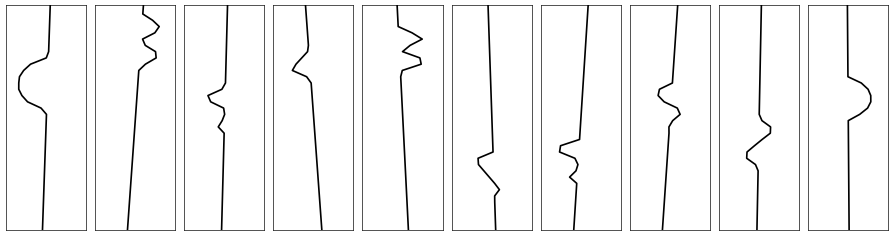

In [9]:

args = get_dataset_args()
args.iid_noise_scale = 0.0  # turn off iid noise for visualization
args.corr_noise_scale = 0.0  # turn off correlated noise for visualization
data = make_dataset(args=args)
xs = data['x_test'][1:11]
t = data['t']
_ = plot_signals(xs, t, args=args, ratio=2.7, zoom=6)

In [10]:

class MNIST1D_Dataset():
   
   def __init__(self, seed = None): 

      
      self.data_args = self.get_dataset_args(as_dict=False)

      self.data_args_dict = self.get_dataset_args(as_dict=True)
      
      self.model_args = self.get_model_args(as_dict=False)
      
      self.model_args_dict = self.get_model_args(as_dict=True)
      
      if not seed: 
         self.set_seed(self.data_args.seed)
      else: 
         self.set_seed(seed)
         
      # print("The Arguments for Data are: ")
      # print("num_samples: 5000 \n train_split: 0.8 \n template_len: 12 \n padding: [36,60] \n scale_coeff: .4 \n max_translation: 48 \n corr_noise_scale: 0.25 \n iid_noise_scale: 2e-2 \n shear_scale: 0.75 \n shuffle_seq: False \n final_seq_length: 40 \n seed: 42")
      
      # print("\n")
      
      # print("The Arguments for Model are: ")
      # print("input_size: 40 \n output_size: 10 \n hidden_size: 256 \n learning_rate: 1e-2 \n weight_decay: 0 \n batch_size: 100 \n total_steps: 6000 \n print_every: 1000 \n eval_every: 250 \n checkpoint_every: 1000 \n device: mps \n seed: 42")


   
   def make_dataset(self): 
      data = make_dataset(self.data_args)
      # Creating dataset of size [Batch, channels, tokens]
      data['x'] = torch.Tensor(data['x']).unsqueeze(1)
      data['x_test'] = torch.Tensor(data['x_test']).unsqueeze(1)
      return data
   
   @staticmethod
   def set_seed(seed):
      np.random.seed(seed)
      torch.manual_seed(seed)
      torch.cuda.manual_seed_all(seed)
      
   def get_dataset_args(self, as_dict=False):
      arg_dict = {'num_samples': 5000,
               'train_split': 0.8,
               'template_len': 12,
               'padding': [36,60],
               'scale_coeff': .4, 
               'max_translation': 48,
               'corr_noise_scale': 0.25,
               'iid_noise_scale': 2e-2,
               'shear_scale': 0.75,
               'shuffle_seq': False,
               'final_seq_length': 40,
               'seed': 42}
      return arg_dict if as_dict else self.ObjectView(arg_dict)
   
   def get_model_args(self, as_dict=False):
      arg_dict = {'input_size': 40,
               'output_size': 10,
               'hidden_size': 256,
               'learning_rate': 1e-2,
               'weight_decay': 0,
               'batch_size': 100,
               'total_steps': 6000,
               'print_every': 1000,
               'eval_every': 250,
               'checkpoint_every': 1000,
               'device': 'mps',
               'seed': 42}
      return arg_dict if as_dict else self.ObjectView(arg_dict)
   
   @staticmethod
   class ObjectView(object):
      def __init__(self, d): self.__dict__ = d
      
class MNIST1D_Plot(): 
   def __init__(self, data=None, data_args=None):
      self.data = data
      self.data_args = data_args
      
   
   '''Functions for Transformation'''
   def pad(self, x, padding): 
      low, high = padding
      p = low + int(np.random.rand()*(high-low+1))
      return np.concatenate([x, np.zeros((p))])

   def shear(self, x, scale=10):
      coeff = scale*(np.random.rand() - 0.5)
      return x - coeff*np.linspace(-0.5,.5,len(x))

   def translate(self, x, max_translation):
      k = np.random.choice(max_translation)
      return np.concatenate([x[-k:], x[:-k]])

   def corr_noise_like(self, x, scale):
      noise = scale * np.random.randn(*x.shape)
      return gaussian_filter(noise, 2)

   def iid_noise_like(self, x, scale):
      noise = scale * np.random.randn(*x.shape)
      return noise

   def interpolate(self, x, N):
      scale = np.linspace(0,1,len(x))
      new_scale = np.linspace(0,1,N)
      new_x = interp1d(scale, x, axis=0, kind='linear')(new_scale)
      return new_x

   def transform(self, x, y, args, eps=1e-8):
      new_x = self.pad(x+eps, args.padding) # pad
      new_x = self.interpolate(new_x, args.template_len + args.padding[-1])  # dilate
      new_y = self.interpolate(y, args.template_len + args.padding[-1])
      new_x *= (1 + args.scale_coeff*(np.random.rand() - 0.5))  # scale
      new_x = self.translate(new_x, args.max_translation)  #translate
      
      # add noise
      mask = new_x != 0
      new_x = mask*new_x + (1-mask)*self.corr_noise_like(new_x, args.corr_noise_scale)
      new_x = new_x + self.iid_noise_like(new_x, args.iid_noise_scale)
      
      # shear and interpolate
      new_x = self.shear(new_x, args.shear_scale)
      new_x = self.interpolate(new_x, args.final_seq_length) # subsample
      new_y = self.interpolate(new_y, args.final_seq_length)
      return new_x, new_y
   
   
   '''Additional Functions for plotting'''
   def apply_ablations(self, arg_dict, n=7): 
      ablations = [('shear_scale', 0),
                  ('iid_noise_scale', 0),
                  ('corr_noise_scale', 0),
                   ('max_translation', 1),
                   ('scale_coeff', 0),
                   ('padding', [arg_dict['padding'][-1], arg_dict['padding'][-1]]),
                   ('padding', [0, 0]),]
      num_ablations = min(n, len(ablations))
      for i in range(num_ablations):
          k, v = ablations[i]
          arg_dict[k] = v
      return arg_dict
   
   def get_templates(self):
      d0 = np.asarray([5,6,6.5,6.75,7,7,7,7,6.75,6.5,6,5])
      d1 = np.asarray([5,3,3,3.4,3.8,4.2,4.6,5,5.4,5.8,5,5])
      d2 = np.asarray([5,6,6.5,6.5,6,5.25,4.75,4,3.5,3.5,4,5])
      d3 = np.asarray([5,6,6.5,6.5,6,5,5,6,6.5,6.5,6,5])
      d4 = np.asarray([5,4.4,3.8,3.2,2.6,2.6,5,5,5,5,5,5])
      d5 = np.asarray([5,3,3,3,3,5,6,6.5,6.5,6,4.5,5])
      d6 = np.asarray([5,4,3.5,3.25,3,3,3,3,3.25,3.5,4,5])
      d7 = np.asarray([5,7,7,6.6,6.2,5.8,5.4,5,4.6,4.2,5,5])
      d8 = np.asarray([5,4,3.5,3.5,4,5,5,4,3.5,3.5,4,5])
      d9 = np.asarray([5,4,3.5,3.5,4,5,5,5,5,4.7,4.3,5])

      x = np.stack([d0,d1,d2,d3,d4,d5,d6,d7,d8,d9])
      x -= x.mean(1,keepdims=True) # whiten
      x /= x.std(1,keepdims=True)
      x -= x[:,:1]  # signal starts and ends at 0

      templates = {'x': x/6., 't': np.linspace(-5, 5, len(d0))/6.,
               'y': np.asarray([0,1,2,3,4,5,6,7,8,9])}
      return templates
   
   @staticmethod
   class ObjectView(object):
      def __init__(self, d): self.__dict__ = d
 
   '''Plotting Functions'''

   # Main plotting function for MNIST1D data -> I do not think this necessarily has to be in the class
   # Can be an individual function
   def plot_signals(self, xs, t, labels=None, args=None, title=None, ratio=2.6, do_transform=False, dark_mode=False, zoom=1):
      

      rows, cols = 1, 10
      fig = plt.figure(figsize=[cols*1.5,rows*1.5*ratio], dpi=60)
      for r in range(rows):
         for c in range(cols):
            ix = r*cols + c
            x, t = xs[ix], t
            
            # Ensure x is a 1D array if it's a 2D array with a single row
            if x.ndim > 1 and x.shape[0] == 1:
                x = x.squeeze(0)
            ax = plt.subplot(rows,cols,ix+1)

            # plot the data
            if do_transform:
                  assert args is not None, "Need an args object in order to do transforms"
                  x, t = self.transform(x, t, args)  # optionally, transform the signal in some manner
            if dark_mode:
                  plt.plot(x, t, 'wo', linewidth=6)
                  ax.set_facecolor('k')
            else:
                  plt.plot(x, t, 'k-', linewidth=2)
            if labels is not None:
                  plt.title("label=" + str(labels[ix]), fontsize=22)
            plt.xlim(-zoom,zoom) ; plt.ylim(-zoom,zoom)
            plt.gca().invert_yaxis() ; plt.xticks([], []), plt.yticks([], [])
      if title is None:
         fig.suptitle('Noise free', fontsize=24, y=1.1)
      else:
         fig.suptitle(title, fontsize=24, y=1.1)
      plt.subplots_adjust(wspace=0, hspace=0)
      plt.tight_layout() ; plt.show()
      

In [11]:
noisy_dataset = MNIST1D_Dataset()
print(noisy_dataset.data_args.iid_noise_scale, noisy_dataset.data_args.corr_noise_scale)
noisy_data = noisy_dataset.make_dataset()


0.02 0.25


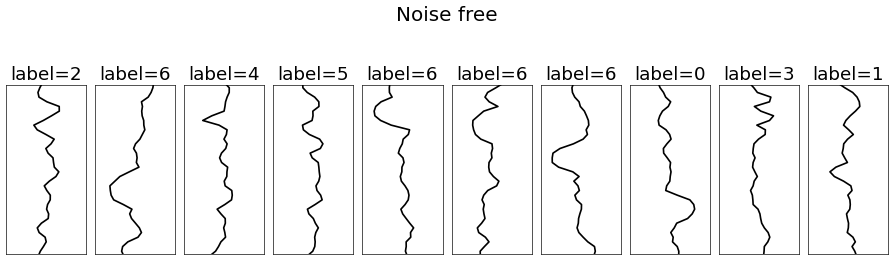

torch.Size([1, 40])
()


In [12]:
clean_dataset = MNIST1D_Dataset()
clean_dataset.data_args.iid_noise_scale = 0.0
clean_dataset.data_args.corr_noise_scale = 0.0
# print(clean_dataset.data_args.iid_noise_scale, clean_dataset.data_args.corr_noise_scale)

clean_data = clean_dataset.make_dataset()

Plot = MNIST1D_Plot()

Plot.plot_signals(noisy_data['x'][:10], noisy_data['t'], labels=noisy_data['y'][:10], zoom = 5, title='Noise free')

print(noisy_data['x'][0].shape)
print(noisy_data['y'][0].shape)